# 02 Notebook exercise:

Consider the following boundary value problem for the 1D wave equation:

\begin{align}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}(x,t)-\frac{\partial^2 u}{\partial x^2}(x,t)&=0, \\
  u(0,t)=u(10,t)&= 0, \\
  \frac{\partial u}{\partial t}(x,0)&=0, \\
  u(x,0)&=
    \begin{cases}
      0, & 0 \leq x < 4,\\
      1, & 4 \leq x \leq 6,\\
      0, & 6 < x \leq 10.
    \end{cases}
\end{align}

The initial state is illustrated in the figure below:

<img src="figures/exact_solution.png" width="450" height="450" align="center"/>

The exact solution can be written as:
\begin{equation}
 u(x,t)=\sum_{n=1}^{\infty}A_{n}\sin\left(\frac{n\pi x}{10}\right)\cos\left(\frac{n\pi ct}{10}\right),
\end{equation}
where
\begin{equation}
  A_n=\frac{2}{n\pi}\left[\cos\left(\frac{4n\pi}{10}\right)-\cos\left(\frac{6n\pi}{10}\right)\right].
\end{equation}

A potential Devito implementation is outlined below:

In [1]:
from numpy import sin, cos, pi, linspace, shape, zeros, mod

import matplotlib.pyplot as plt

# Global constants
L = 10. # Define length of domain as a global variable
N = 2000 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
c = 1.0 # Speed of sound

x = linspace(0, L, l) # x axis for calling u(x, t) at given t

# Calculate exact solution

def u_e(x, t):
    s = zeros(x.size)
    for i in range(1,N+1):
        s+=A_n(i)*sin(i*pi*x/L)*cos(i*pi*c*t/L)
    return s

def A_n(n):
    const = 2/n/pi*(cos(4*n*pi/L)-cos(6*n*pi/L))
    return const

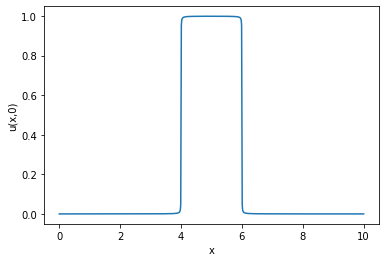

In [2]:
%matplotlib inline
# Plot solution at a point T in time
T = 0
plt.plot(x, u_e(x, T))
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.show()

In [3]:
# Devito implimentation

time_order = 2
space_order = 2

In [4]:


# Required imports
from devito import Grid, TimeFunction, Eq, solve, Operator

# Define the grid/computational domain
grid = Grid(shape=(l), extent=(L))
t_s = grid.stepping_dim

# Wavefield
u = TimeFunction(name='u', grid=grid, time_order=time_order, space_order=space_order)

dx = abs(x[1]-x[0])
# Critical time-step
dt = 0.004 # (dt < 0.42*dx/c)

# Define the equation and boundary conditions
pde = 1/c**2*u.dt2-u.dx2
eq = Eq(u.forward, solve(pde, u.forward))
bc = [Eq(u[t_s+1, 0], 0)]
bc += [Eq(u[t_s+1, -1], 0)]

# Set the initial conditions
u0 = u_e(x, 0)
u1 = u_e(x, dt)
u.data[0,:] = u0
u.data[1,:] = u1

# Create the Devito Operator
op = Operator([eq]+bc)

In [5]:
# Now lets run the operator
op.apply(time_m=1, time_M=4999, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0009350000000000162, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

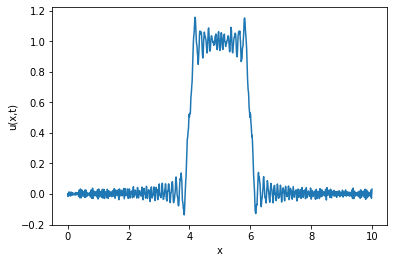

In [6]:
%matplotlib inline
# Lets plot some Devito results:
plt.plot(x, u.data[mod(5000,3), :])
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.show()

Note that we can improve this result through using higher order schemes.